In [ ]:
## Creating a Separate Virtual Environment 
# conda create -n tigerCaseStudy python=3

In [2]:
!conda activate tigerCaseStudy



In [1]:
import pandas as pd
import pyodbc
from datetime import datetime
import numpy as np
import warnings 
warnings.filterwarnings('ignore')

In [2]:
conn_str = ("Driver={SQL Server Native Client 11.0};"
            "Server=mskl-db-server.database.windows.net;"
            "Database=tigeranalytics;"
            "UID=tigerlearner;"
            "PWD=AsDf1234;")
conn = pyodbc.connect(conn_str)

In [3]:
# Creating a cursor
# cur = conn.cursor()


#### Number of orders having unusual discounts as per 6 dimensions of data quality?

In [24]:
query = "select count(order_id) as unsual_discount from marketing_transaction where grand_total <=0 and discount_amount>0"
pd.read_sql(query, conn)

unsual_discount
0            12689

#### Minimum of "qty_ordered" column among one time orders placed by customers?

In [26]:
query = """select min(min_ords) as min_qty_ord  
from (SELECT trans.customer_id, min(trans.qty_ordered) as min_ords 
  FROM marketing_transaction trans 
  INNER join marketing_orders ord on trans.order_id = ord.order_id
  GROUP by trans.customer_id
  HAVING count(trans.order_id)=1) A"""
pd.read_sql(query, conn)

min_qty_ord
0            0

#### Let's check which 5 customers are prime regular customers for each segment according to their placing orders. 

In [28]:
query = """SELECT  B.category, B.customer_name, B.total_orders FROM
(SELECT  A.category_name AS category,cust.name AS customer_name,A.qty AS total_orders
	       ,Row_NUMBER() OVER(PARTITION BY A.category_name ORDER BY A.qty DESC) RNum
	FROM (SELECT  category_name,customer_id,COUNT(ord.order_id) AS qty
		FROM marketing_orders ord
		GROUP BY  category_name,customer_id) A
	INNER JOIN marketing_customer cust
	ON A.customer_id = cust.customer_id) B
WHERE B.RNum <= 5 """
pd.read_sql(query, conn)


category                 customer_name  total_orders
0              None               Bakiono Mandala             1
1              None     Tgk. Yulia Marpaung, S.Pd             1
2              None                Yuliana Waluyo             1
3              None              Karimah Wibisono             1
4              None  R.A. Unjani Situmorang, S.Pd             1
..              ...                           ...           ...
80  Women's Fashion          R. Ivan Marbun, S.IP            17
81  Women's Fashion              Harjasa Sihotang            15
82  Women's Fashion                Paiman Riyanti            14
83  Women's Fashion         Zelaya Samosir, S.Kom            14
84  Women's Fashion                 Banara Melani            14

[85 rows x 3 columns]

##### It’s a big deal to know which product’s demand is more in each category among our customers. So we can analyze which product gives us more sales. 


In [29]:
query = """SELECT TOP 100 ord.category_name AS category,
 sum(trans.qty_ordered) AS qty, 
 sum(trans.grand_total) AS sales
from  marketing_transaction trans
INNER JOIN marketing_orders ord ON trans.order_id = ord.order_id 
where qty_ordered>=0
GROUP BY ord.category_name
ORDER BY sales DESC"""
pd.read_sql(query, conn)


category     qty         sales
0    Mobiles & Tablets  324191  2.554552e+09
1           Appliances  123748  6.600631e+08
2        Entertainment   39355  5.531503e+08
3      Women's Fashion  246073  2.989547e+08
4            Computing   45404  2.036642e+08
5        Men's Fashion  307217  1.969912e+08
6               Others  702110  1.926591e+08
7           Superstore  930570  1.113166e+08
8    Beauty & Grooming  275267  1.000471e+08
9        Home & Living  242958  8.827220e+07
10         Kids & Baby  139064  4.799637e+07
11             Soghaat  268023  4.698335e+07
12     Health & Sports  112631  4.224610e+07
13                  \N  174856  3.612900e+07
14  School & Education   31882  5.832447e+06
15               Books    7133  4.253946e+06
16                None    2575  2.731000e+05

#### RFM Analysis

Fetching Raw data

In [11]:
# # executing data query
# cur.execute("SELECT ord.order_id, ord.customer_id, order_purchase_date, order_customer_delivery_date, trans_id, price, discount_amount, qty_ordered, grand_total, trans_date FROM marketing_orders ord INNER JOIN marketing_transaction trans ON ord.order_id = trans.order_id")
# data = cur.fetchall()


In [4]:
query = """SELECT ord.order_id, ord.customer_id, order_purchase_date, order_customer_delivery_date, 
        trans_id, price, discount_amount, qty_ordered, grand_total, trans_date 
        FROM marketing_orders ord 
        INNER JOIN marketing_transaction trans ON ord.order_id = trans.order_id"""

data_df = pd.read_sql(query, conn)
data_df.head()

order_id    customer_id order_purchase_date  \
0  LTPLOU-2389083  IN-Madh-66468          2017-12-12   
1  IHKOKM-2112423  IN-Sirs-52279          2014-03-01   
2  XWGEEO-2016907  IN-Dhar-21003          2017-01-19   
3  TWGNDX-3940026  IN-Aist-62197          2016-08-23   
4  DGHAGM-4122969  IN-Manj-51104          2018-08-24   

  order_customer_delivery_date         trans_id    price  discount_amount  \
0                   2018-01-22  T0001DYQD0HHUBC    799.0       182.215805   
1                   2014-07-25  T0002NV8P6FV0UU    150.0         0.000000   
2                   2017-05-12  T00044VVX778WE8   8000.0      1000.000000   
3                   2016-10-11  T0008EQVNKBMD6T    699.0         0.000000   
4                   2019-01-06  T00099X49XTK3LO  13698.0      2109.899902   

   qty_ordered   grand_total  trans_date  
0            2   1415.784180  2017-12-12  
1            1    150.000000  2014-03-01  
2            2  15000.000000  2017-01-19  
3            2   1398.000000  2016-08-23  
4            1  11588.099609  2018-08-24

In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615083 entries, 0 to 615082
Data columns (total 10 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   order_id                      615083 non-null  object 
 1   customer_id                   615083 non-null  object 
 2   order_purchase_date           615083 non-null  object 
 3   order_customer_delivery_date  615083 non-null  object 
 4   trans_id                      615083 non-null  object 
 5   price                         615083 non-null  float64
 6   discount_amount               615080 non-null  float64
 7   qty_ordered                   615083 non-null  int64  
 8   grand_total                   615083 non-null  float64
 9   trans_date                    615083 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 46.9+ MB


In [6]:
# Dropping Rows where quantity ordered is equal to zero(0) 
drop_idx = data_df[data_df['qty_ordered']<=0].index # Getting Index of all such rows
data_df.drop(drop_idx, inplace=True)
data_df.head()

order_id    customer_id order_purchase_date  \
0  LTPLOU-2389083  IN-Madh-66468          2017-12-12   
1  IHKOKM-2112423  IN-Sirs-52279          2014-03-01   
2  XWGEEO-2016907  IN-Dhar-21003          2017-01-19   
3  TWGNDX-3940026  IN-Aist-62197          2016-08-23   
4  DGHAGM-4122969  IN-Manj-51104          2018-08-24   

  order_customer_delivery_date         trans_id    price  discount_amount  \
0                   2018-01-22  T0001DYQD0HHUBC    799.0       182.215805   
1                   2014-07-25  T0002NV8P6FV0UU    150.0         0.000000   
2                   2017-05-12  T00044VVX778WE8   8000.0      1000.000000   
3                   2016-10-11  T0008EQVNKBMD6T    699.0         0.000000   
4                   2019-01-06  T00099X49XTK3LO  13698.0      2109.899902   

   qty_ordered   grand_total  trans_date  
0            2   1415.784180  2017-12-12  
1            1    150.000000  2014-03-01  
2            2  15000.000000  2017-01-19  
3            2   1398.000000  2016-08-23  
4            1  11588.099609  2018-08-24

In [7]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 601746 entries, 0 to 615082
Data columns (total 10 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   order_id                      601746 non-null  object 
 1   customer_id                   601746 non-null  object 
 2   order_purchase_date           601746 non-null  object 
 3   order_customer_delivery_date  601746 non-null  object 
 4   trans_id                      601746 non-null  object 
 5   price                         601746 non-null  float64
 6   discount_amount               601743 non-null  float64
 7   qty_ordered                   601746 non-null  int64  
 8   grand_total                   601746 non-null  float64
 9   trans_date                    601746 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 50.5+ MB


In [8]:
data_df[data_df['grand_total']<0].describe()

price  discount_amount  qty_ordered   grand_total
count   2006.000000      2006.000000  2006.000000   2006.000000
mean     792.300618      5384.870847     2.722832  -4239.766673
std     1141.815014      3328.452512     6.346515   2934.246857
min        1.000000        10.000000     1.000000 -15410.000000
25%      198.000000      1052.000000     1.000000  -6451.500000
50%      394.500000      6992.000000     1.000000  -5318.004883
75%      899.000000      7000.000000     2.000000   -698.237503
max    13830.000000     20000.000000   200.000000     -0.200000

Even After dropping rows with quantity ordered(qty_ordered) zero or less, we still have rows where grand total is in negetive. Need to drop those also

In [9]:
drop_idx_nagetive = data_df[data_df['grand_total']<0].index
data_df.drop(drop_idx_nagetive, inplace=True)
data_df.reset_index().head()

index        order_id    customer_id order_purchase_date  \
0      0  LTPLOU-2389083  IN-Madh-66468          2017-12-12   
1      1  IHKOKM-2112423  IN-Sirs-52279          2014-03-01   
2      2  XWGEEO-2016907  IN-Dhar-21003          2017-01-19   
3      3  TWGNDX-3940026  IN-Aist-62197          2016-08-23   
4      4  DGHAGM-4122969  IN-Manj-51104          2018-08-24   

  order_customer_delivery_date         trans_id    price  discount_amount  \
0                   2018-01-22  T0001DYQD0HHUBC    799.0       182.215805   
1                   2014-07-25  T0002NV8P6FV0UU    150.0         0.000000   
2                   2017-05-12  T00044VVX778WE8   8000.0      1000.000000   
3                   2016-10-11  T0008EQVNKBMD6T    699.0         0.000000   
4                   2019-01-06  T00099X49XTK3LO  13698.0      2109.899902   

   qty_ordered   grand_total  trans_date  
0            2   1415.784180  2017-12-12  
1            1    150.000000  2014-03-01  
2            2  15000.000000  2017-01-19  
3            2   1398.000000  2016-08-23  
4            1  11588.099609  2018-08-24

In [10]:
# To calculate recency fixing current date, because last transaction/order date is 20-Dec-2021, so taking '21-Dec-2021'. 
# Getting a customer's recent order date and getting difference between those dates
from datetime import date
current_date = date.fromisoformat('2021-12-21')

df = data_df.groupby('customer_id').agg({'order_purchase_date': lambda x: (current_date - x.max()).days, # Recency
                                        'order_id': lambda x: len(x),      # Frequency
                                        'grand_total': lambda x: x.sum()}) # Monetary
df.rename(columns={'order_purchase_date':'recency','order_id':'frequency','grand_total':'monetary'}, inplace=True)

# df = data_df.groupby('customer_id').agg({'order_purchase_date':'max',  'grand_total':'mean', 'order_id':'count'})
# df['recency'] = df['order_purchase_date'].apply(lambda x: (current_date - x).days)
# df.rename(columns={'order_id':'frequency','grand_total':'monetary'}, inplace=True)
# df.drop('order_purchase_date', axis=1, inplace=True)
df.head()


recency  frequency       monetary
customer_id                                     
IN-Adra-10096     1124          5   17655.400024
IN-Adra-10127       58         10  124299.899902
IN-Adra-10185      926          4   85880.000000
IN-Adra-10214      543          4   77188.399994
IN-Adra-10256      430          2    1394.000000

In [11]:
# Verifying If RFM table data
# Filtering data for customer 'IN-Adra-10096'
data_df[data_df['customer_id']=='IN-Adra-10096'][['customer_id','order_purchase_date','order_id', 'grand_total']]

customer_id order_purchase_date        order_id  grand_total
196364  IN-Adra-10096          2015-06-18  YAFYXQ-3727693  9600.000000
224295  IN-Adra-10096          2014-06-18  YDVLUL-1456215  4000.000000
286851  IN-Adra-10096          2014-07-05  JFDYFQ-1413251  1821.400024
365666  IN-Adra-10096          2016-07-17  GEJEVA-1085111  1559.000000
601214  IN-Adra-10096          2018-11-23  KTYQFP-1882865   675.000000

* Customer 'IN-Adra-10096' have placed total 5 orders 
* Last order placed is on '2018-11-23' and considering current date as '2021-12-21', recency is 1124 days

In [12]:
# df['R_Score'] = (df['recency']//((df['recency'].max() - df['recency'].min())/5))
# df['M_Score'] = (df['monetary']//((df['monetary'].max() - df['monetary'].min())/5))
# df['F_Score'] = (df['frequency']//((df['frequency'].max() - df['frequency'].min())/5))
# df.head()

# df['R_Score'] = (df['recency']//((df['recency'].max() - df['recency'].min())/4))
# df['M_Score'] = (df['monetary']//((df['monetary'].max() - df['monetary'].min())/4))
# df['F_Score'] = (df['frequency']//((df['frequency'].max() - df['frequency'].min())/4))

# Calculating overall score
# ((0.4*df['R_Score']+0.4*df['F_Score']+0.2*df['M_Score'])*100).value_counts()
# df['overall_score'] = ((df['R_Score']+df['F_Score']+df['M_Score'])/3*100)
# df.head()


commented 
<!-- ### Calculating the Customer Group Score based on the RFM Score 
* Promoters - Customers with >90% scores
* Potentials - Customers between 60 and 90% scores
* Detractors - Customers with <60% scores

Max Score obtained is ~133.334 </br>
133.33*0.9 = 119.99 ~= 120 (90% Score) </br>
133.33*0.6 = 79.998 ~= 80 (60% Score) </br> -->
--


In [13]:
# # df['overall_score'].value_counts()
# df['group'] = df['overall_score'].apply(lambda x: 'Detractors' if x<80.0 else ('Promoters' if x>120.0 else 'Potentials'))
# df.head()
# # type(df['overall_score'][0])

RFM analysis involves categorising R,F and M into categories.  </br>
Creating 4 categories based on quartiles (quartiles roughly divide the data into 4 segments equal proportion).

In [14]:
quantiles = df.quantile(q=[0.25,0.50,0.75])
print(quantiles)

      recency  frequency      monetary
0.25    147.0        4.0  14639.737457
0.50    356.0        5.0  31823.699997
0.75    709.0        7.0  62617.049835


In [15]:
# It's more convenient to use data in dictionary 
quantiles = quantiles.to_dict()
print(quantiles)

{'recency': {0.25: 147.0, 0.5: 356.0, 0.75: 709.0}, 'frequency': {0.25: 4.0, 0.5: 5.0, 0.75: 7.0}, 'monetary': {0.25: 14639.73745727539, 0.5: 31823.699996948242, 0.75: 62617.04983520508}}


In [16]:
### Categorising R,F,M data into classes based on the quartiles 
# Class score is calculated, for frequency and Monetary is value is big then class is 1 and with reducing score class should be 2,3 and 4. 
# For Recency, because less recency is good, so need to reverse the categorising scheme.

# Arguments (x = value, p = recency, monetary, frequency, k = quartiles dict)
## for Recency 
def RClass(x,p,k):
    if x <= k[p][0.25]:
        return 1
    elif x <= k[p][0.50]:
        return 2
    elif x <= k[p][0.75]: 
        return 3
    else:
        return 4
    
## for Frequency and Monetary value 
def FMClass(x,p,k):
    if x <= k[p][0.25]:
        return 4
    elif x <= k[p][0.50]:
        return 3
    elif x <= k[p][0.75]: 
        return 2
    else:
        return 1    
    

In [17]:

df['R_Quartile'] = df['recency'].apply(RClass, args=('recency',quantiles,))
df['F_Quartile'] = df['frequency'].apply(FMClass, args=('frequency',quantiles,))
df['M_Quartile'] = df['monetary'].apply(FMClass, args=('monetary',quantiles,))

In [18]:
# Combine Score of R, F, and M quartile to create a RFM Score, This will create a score between 3 to 12.  
df['RFM_Score'] = df['R_Quartile'] + df['F_Quartile'] +df['M_Quartile']
df.head(10)

recency  frequency       monetary  R_Quartile  F_Quartile  \
customer_id                                                                
IN-Adra-10096     1124          5   17655.400024           4           3   
IN-Adra-10127       58         10  124299.899902           1           1   
IN-Adra-10185      926          4   85880.000000           4           4   
IN-Adra-10214      543          4   77188.399994           3           4   
IN-Adra-10256      430          2    1394.000000           3           4   
IN-Adra-10273      398          8   23334.599976           3           1   
IN-Adra-10283      287          9  146597.799805           2           1   
IN-Adra-10332       62          3   46223.900391           1           4   
IN-Adra-10356     1050          3    1365.829994           4           4   
IN-Adra-1037       536          5   86591.720703           3           3   

               M_Quartile  RFM_Score  
customer_id                           
IN-Adra-10096           3         10  
IN-Adra-10127           1          3  
IN-Adra-10185           1          9  
IN-Adra-10214           1          8  
IN-Adra-10256           4         11  
IN-Adra-10273           3          7  
IN-Adra-10283           1          4  
IN-Adra-10332           2          7  
IN-Adra-10356           4         12  
IN-Adra-1037            1          7

In [19]:
df['monetary'].describe()

count    1.040140e+05
mean     4.969706e+04
std      1.476072e+05
min      0.000000e+00
25%      1.463974e+04
50%      3.182370e+04
75%      6.261705e+04
max      1.804345e+07
Name: monetary, dtype: float64

### Calculating the Customer Group Score based on the RFM Score 
* Promoters - Customers with >90% scores
* Potentials - Customers between 60 and 90% scores
* Detractors - Customers with <60% scores

In [20]:
# Because we want to get top above 90% customers, so we taking 10 percentile score customers and 
# same for people above 60% and less then 90% take 40 percentile customers 
df['RFM_Score'].quantile([0.1,0.4])

0.1    4.0
0.4    7.0
Name: RFM_Score, dtype: float64

In [24]:
# # RFM Score 90% is 11 and 60% is 8, So segmenting customers on RFM Score basis
# # df['group'] = df['RFM_Score'].apply(lambda x: 'Detractors' if x<8.0 else ('Promoters' if x>11.0 else 'Potentials'))
# t = df['RFM_Score'].apply(lambda x: 'Detractors' if x>7.0 else ('Promoters' if x<4.0 else 'Potentials')).value_counts()
# # total_customers = df.shape[0]
# # print(f'Total Customers: {total_customers}')
# # df['group'].value_counts()
# # # type(df['overall_score'][0])
# total_customers = df.shape[0]

# for k, v in t.items():
#     print(f"{round((v/total_customers)*100,2)}% of total customers is in '{k}' group")

In [25]:
# Customer Segmentation on RFM Score 
df['group'] = df['RFM_Score'].apply(lambda x: 'Detractors' if x>7.0 else ('Promoters' if x<4.0 else 'Potentials'))
total_customers = df.shape[0]
print(f'Total Customers: {total_customers}')
df['group'].value_counts()
# type(df['overall_score'][0])

Total Customers: 104014


Detractors    52609
Potentials    47057
Promoters      4348
Name: group, dtype: int64

In [26]:
print('Segmentation of Customers') 
for k, v in df['group'].value_counts().items():
    print(f"{round((v/total_customers)*100,2)}% of total customers is in '{k}' group")

Segmentation of Customers
50.58% of total customers is in 'Detractors' group
45.24% of total customers is in 'Potentials' group
4.18% of total customers is in 'Promoters' group


In [27]:
df.groupby('RFM_Score').agg({'monetary':'mean'})

monetary
RFM_Score               
3          139254.625840
4           99962.720287
5           76335.484254
6           65417.963154
7           51832.298808
8           38716.013040
9           30329.440988
10          19479.233136
11          13526.590480
12           5982.331042

<AxesSubplot: xlabel='RFM_Score'>

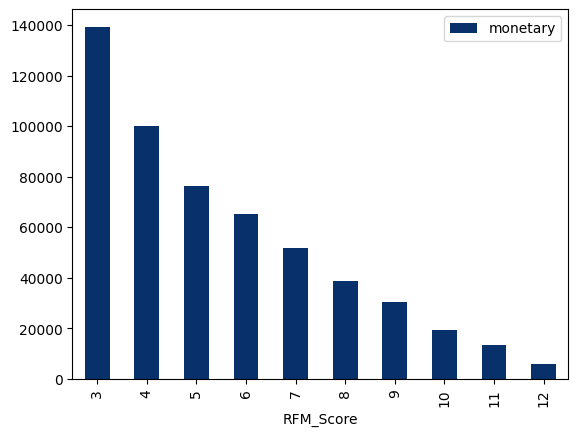

In [28]:
import matplotlib.pyplot as plt
df.groupby('RFM_Score').agg({'monetary':'mean'}).plot(kind='bar', colormap='Blues_r')

### RFM Analysis without dropping row where grand_total is negative 

In [34]:
# Getting Raw data 
query = "SELECT ord.order_id, ord.customer_id, order_purchase_date, order_customer_delivery_date, trans_id, price, discount_amount, qty_ordered, grand_total, trans_date FROM marketing_orders ord INNER JOIN marketing_transaction trans ON ord.order_id = trans.order_id"

data_df = pd.read_sql(query, conn)

# To calculate recency fixing current date, because last transaction/order date is 20-Dec-2021, so taking '21-Dec-2021'. 
# Getting a customer's recent order date and getting difference between those dates
from datetime import date
current_date = date.fromisoformat('2021-12-21')

df = data_df.groupby('customer_id').agg({'order_purchase_date': lambda x: (current_date - x.max()).days, # Recency
                                        'order_id': lambda x: len(x),      # Frequency
                                        'grand_total': lambda x: x.sum()}) # Monetary
df.rename(columns={'order_purchase_date':'recency','order_id':'frequency','grand_total':'monetary'}, inplace=True)

print(df.head())
quantiles = df.quantile(q=[0.25,0.50,0.75])
quantiles = quantiles.to_dict()
print('Quantiles',quantiles)

df['R_Quartile'] = df['recency'].apply(RClass, args=('recency',quantiles,))
df['F_Quartile'] = df['frequency'].apply(FMClass, args=('frequency',quantiles,))
df['M_Quartile'] = df['monetary'].apply(FMClass, args=('monetary',quantiles,))
# Combine Score of R, F, and M quartile to create a RFM Score, This will create a score between 3 to 12.  
df['RFM_Score'] = df['R_Quartile'] + df['F_Quartile'] +df['M_Quartile']
# df.head(10)
df['RFM_Score'].quantile([0.1,0.4])

df['group'] = df['RFM_Score'].apply(lambda x: 'Detractors' if x>7.0 else ('Promoters' if x<4.0 else 'Potentials'))

total_customers = df.shape[0]
print('Segmentation of Customers')
for k, v in df['group'].value_counts().items():
    print(f"{round((v/total_customers)*100,2)}% of total customers is in '{k}' group")

               recency  frequency       monetary  R_Quartile  F_Quartile  \
customer_id                                                                
IN-Adra-10096     1124          5   17655.400024           4           3   
IN-Adra-10127       58         10  124299.899902           1           1   
IN-Adra-10185      926          4   85880.000000           4           4   
IN-Adra-10214      543          4   77188.399994           3           4   
IN-Adra-10256      430          2    1394.000000           3           4   

               M_Quartile  RFM_Score  group  
customer_id                                  
IN-Adra-10096           3         10    NaN  
IN-Adra-10127           1          3    NaN  
IN-Adra-10185           1          9    NaN  
IN-Adra-10214           1          8    NaN  
IN-Adra-10256           4         11    NaN  
Quantiles {'recency': {0.25: 144.0, 0.5: 347.0, 0.75: 693.0}, 'frequency': {0.25: 4.0, 0.5: 6.0, 0.75: 7.0}, 'monetary': {0.25: 14402.41723632812

#### Is there any city that comes in the red zone for late delivery? Redzone is defined when avg delay hr> overall avg delay hrs


In [42]:
query = """with city_table AS (SELECT ord.order_id, cust.city,
DATEDIFF(HOUR, order_estimated_delivery_date, order_customer_delivery_date) as diff
FROM marketing_orders ord 
INNER JOIN marketing_customer cust ON ord.customer_id = cust.customer_id
)

select A.*,
case when avg_delay_hrs> overall_avg_delay_hrs then 'yes' else 'no' END as red_zone FROM
(SELECT city, 
AVG(city_table.diff) as avg_delay_hrs, (select AVG(city_table.diff) from city_table WHERE city_table.diff>=0) as overall_avg_delay_hrs
 FROM city_table
WHERE city_table.diff>=0
GROUP BY city_table.city) A"""
data = pd.read_sql(query, conn)
data.head(10)

city  avg_delay_hrs  overall_avg_delay_hrs red_zone
0         Adra            121                    120      yes
1      Aistala            118                    120       no
2       Aklera            117                    120       no
3       Alwaye            118                    120       no
4       Amreli            120                    120       no
5    Bachhraon            119                    120       no
6       Barbil            120                    120       no
7      Barpeta            120                    120       no
8  Betamcherla            119                    120       no
9    Bhayandar            120                    120       no

In [43]:
# Filtering red_zone areas 
data[data['red_zone']=='yes']


city  avg_delay_hrs  overall_avg_delay_hrs red_zone
0              Adra            121                    120      yes
10           Bhuban            121                    120      yes
13          Chharra            121                    120      yes
14   Dalsingh Sarai            121                    120      yes
16            Deoli            121                    120      yes
18  Diamond Harbour            121                    120      yes
21     Gajendragarh            121                    120      yes
34           Kundla            121                    120      yes
37        Madhipura            121                    120      yes
45           Parola            121                    120      yes
49       Puducherry            121                    120      yes
50           Pujali            122                    120      yes
61            Sojat            121                    120      yes

#### Analysis on Campaign Sample data

In [4]:
# Read the csv file 
df = pd.read_csv('campaign_sample.csv')
df.head()

customer_id  treatment  conversion  visit  exposure       class
0  IN-Hung-15894          1           0      0         0  Lost Cause
1  IN-Jais-17512          0           0      0         0  Lost Cause
2  IN-Akle-17369          1           0      0         0  Lost Cause
3  IN-Deol-71539          0           0      0         0  Lost Cause
4   IN-Puja-7705          0           0      0         0  Lost Cause

#### In the case of an order refund, to which class of campaign do most numbers of customers belong? Take a snapshot of your output table and upload it here

In [ ]:
# Getting Customers data where status is refunded 
query = """select order_id, customer_id, [status] from marketing_orders
where [status]='order_refunded'"""
refund_df = pd.read_sql(query, conn)
refund_df.head()


In [69]:
# Merge dataframe where refund status given and campaign sample data
refund_df.merge(df, on='customer_id', how='inner')['class'].value_counts()

Lost Cause      79
Persuadables     4
Sure Thing       1
Dont Disturb     1
Name: class, dtype: int64

* In the case of order refund, most of the customers belongs to the 'Lost Cause' group 

**The percentage of users who were given the treatment and fully exposed and converted**

In [61]:
data = df[(df['treatment']==1) & (df['exposure']==1) & (df['conversion']==1)]
print(data)
print(f"Total {str(round(data.shape[0]/len(df)*100,2))}% customer(s) are converted when given treatment while they fully exposed")

      customer_id  treatment  conversion  visit  exposure         class
68  IN-Barp-72418          1           1      1         1  Persuadables
Total 0.71% customer(s) are converted when given treatment while they fully exposed


**The percentage of users who were given the treatment but not fully exposed and visited**

In [73]:
tmp_data = df[(df['treatment']==1) & (df['exposure']==0) & (df['visit']==1)]
tmp_data

customer_id  treatment  conversion  visit  exposure         class
36   IN-Alwa-25244          1           0      1         0    Sure Thing
89   IN-Hung-88097          1           0      1         0  Persuadables
98   IN-Kund-68646          1           0      1         0  Persuadables
108   IN-Akle-1617          1           0      1         0  Persuadables
116   IN-Tiru-8232          1           1      1         0  Persuadables
130  IN-Puja-51600          1           1      1         0  Persuadables
139  IN-Cham-94002          1           0      1         0  Persuadables

In [72]:
print(f"Total {str(round(tmp_data.shape[0]/len(df)*100,2))}% customer(s) visited were given treatment but not fully exposed")


Total 5.0% customer(s) visited were given treatment but not fully exposed


**All the product categories which have been effectively exposed to advertisements and marketing have increased sales.**

In [5]:
query = """select ord.order_id, ord.customer_id, ord.category_name, ord.status, trans.grand_total
         from marketing_orders ord
         inner join marketing_transaction trans on ord.order_id = trans.order_id
         """
category_df = pd.read_sql(query, conn)
category_df.head()


order_id    customer_id      category_name          status  \
0  AAAAMW-3995324  IN-Akle-93299  Beauty & Grooming        complete   
1  AAAANA-4959113   IN-Alwa-4930    Women's Fashion  order_refunded   
2  AAABRP-2231145  IN-Paro-56808  Mobiles & Tablets        complete   
3  AAABWG-4160771  IN-Tiru-53045         Appliances        complete   
4  AAACYU-3911274  IN-Elam-97126         Appliances        complete   

    grand_total  
0   1325.000000  
1   1312.000000  
2  11200.000000  
3  11359.000000  
4   4229.100098

In [6]:
# merging category dataframe and campaign data 
merged_df = category_df.merge(df, on='customer_id', how='inner')
merged_df.head(10)

order_id    customer_id      category_name          status  \
0  AAGDLF-2478987  IN-Rang-73442                 \N        complete   
1  FDYQHV-4150350  IN-Rang-73442  Mobiles & Tablets        canceled   
2  FMHDQD-3878232  IN-Rang-73442      Home & Living  order_refunded   
3  GUJMDJ-1540395  IN-Rang-73442    Women's Fashion        received   
4  LTRHFE-2615959  IN-Rang-73442    Women's Fashion          refund   
5  MJPCER-3129667  IN-Rang-73442         Appliances        received   
6  OJSUGJ-4746541  IN-Rang-73442            Soghaat        complete   
7  SXQXLJ-2353329  IN-Rang-73442      Men's Fashion        complete   
8  AAQNRL-4297786  IN-Kund-68646    Women's Fashion        received   
9  BPQMIE-3130624  IN-Kund-68646  Mobiles & Tablets        canceled   

   grand_total  treatment  conversion  visit  exposure         class  
0       950.00          1           0      0         0    Lost Cause  
1     83770.00          1           0      0         0    Lost Cause  
2      2710.00          1           0      0         0    Lost Cause  
3      2294.25          1           0      0         0    Lost Cause  
4       899.00          1           0      0         0    Lost Cause  
5      3102.00          1           0      0         0    Lost Cause  
6      1200.00          1           0      0         0    Lost Cause  
7      2080.00          1           0      0         0    Lost Cause  
8     10000.00          1           0      1         0  Persuadables  
9       705.00          1           0      1         0  Persuadables

In [7]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 834 entries, 0 to 833
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   order_id       834 non-null    object 
 1   customer_id    834 non-null    object 
 2   category_name  834 non-null    object 
 3   status         834 non-null    object 
 4   grand_total    834 non-null    float64
 5   treatment      834 non-null    int64  
 6   conversion     834 non-null    int64  
 7   visit          834 non-null    int64  
 8   exposure       834 non-null    int64  
 9   class          834 non-null    object 
dtypes: float64(1), int64(4), object(5)
memory usage: 71.7+ KB


In [8]:
merged_df.groupby('exposure').agg('grand_total').mean().to_dict()


{0: 7415.2441843818215, 1: 6606.192220052083}

We will compare customers on the basis of average of grand total because if we take only sum then there is a possibility that total number of customer who got exposure is less then the customer who not got exposure </br>
When comparing it's evidant that after getting exposure total sales are not increased 


**The class of "Lost casue" have generated highest revenue for the product category books**

In [9]:
merged_df.head()

order_id    customer_id      category_name          status  \
0  AAGDLF-2478987  IN-Rang-73442                 \N        complete   
1  FDYQHV-4150350  IN-Rang-73442  Mobiles & Tablets        canceled   
2  FMHDQD-3878232  IN-Rang-73442      Home & Living  order_refunded   
3  GUJMDJ-1540395  IN-Rang-73442    Women's Fashion        received   
4  LTRHFE-2615959  IN-Rang-73442    Women's Fashion          refund   

   grand_total  treatment  conversion  visit  exposure       class  
0       950.00          1           0      0         0  Lost Cause  
1     83770.00          1           0      0         0  Lost Cause  
2      2710.00          1           0      0         0  Lost Cause  
3      2294.25          1           0      0         0  Lost Cause  
4       899.00          1           0      0         0  Lost Cause

In [10]:
tmp_df = merged_df[(merged_df['category_name']=='Books') & (merged_df['class']=='Lost Cause')]
# merged_df['category_name'].value_counts()
tmp_df

order_id    customer_id category_name          status  \
52   UQYFAF-4905002  IN-Pune-47688         Books        canceled   
113  TQEWKM-4291787  IN-Pudu-50560         Books        complete   
150  UAAARF-3125570   IN-Tiru-5044         Books  order_refunded   
686  YOPPGC-1062424  IN-Moga-84430         Books             cod   

      grand_total  treatment  conversion  visit  exposure       class  
52     486.500000          1           0      0         0  Lost Cause  
113    150.000000          1           0      0         0  Lost Cause  
150    764.400024          0           0      0         0  Lost Cause  
686  32525.000000          1           0      0         0  Lost Cause

**The total revenue generated by "persuadable class" customers when they are effectively exposed and treated is greater than when they are not exposed but treated**

In [16]:
merged_df[(merged_df['class']=='Persuadables') & (merged_df['treatment']==1)].groupby('exposure').agg('grand_total').sum()

exposure
0    123656.089294
1     33126.810059
Name: grand_total, dtype: float64

In [13]:
merged_df[merged_df.status=='closed']

order_id    customer_id    category_name  status  grand_total  \
278  YQDCMV-1738937  IN-Puja-66326  Women's Fashion  closed       2400.0   

     treatment  conversion  visit  exposure       class  
278          1           0      0         1  Lost Cause

In [ ]:
# tmp_df['grand_total'].apply(lambda x: ((x - tmp_df['grand_total'].min())/(tmp_df['grand_total'].max() - tmp_df['grand_total'].min())))